# Healthy assessment by predicting the number of steps from calories consumed





## Introduction
The number of steps is generally used as an indicator of a person's physical activity level, and by predicting the number of steps, it is possible to monitor the person's physical activity level and suggest necessary actions. Specifically, by presenting a prediction of the number of steps, the system can help maintain a healthy lifestyle and prevent sedentary behavior.
And while it is important to make predictions based on the number of steps taken, we thought that evaluating the number of steps taken based on the calories actually consumed by a healthy person would provide a more useful health assessment based on the number of steps taken.
As a method for this evaluation, the number of steps taken based on the calorie consumption of a healthy person is learned using time series prediction models. Then, the number of steps taken by a healthy person is predicted based on the calories consumed, and the difference between the number of steps taken by a healthy person and the actual number of steps taken can be checked. From this, we believe that the number of steps is an easy-to-understand indicator that can be used to make people more aware of their daily activities.

## Problem statement
The dataset used is kaggle : FitBit Fitness Tracker Data.
This dataset is a minute-by-minute data set of physical activity, heart rate, and sleep monitoring for 30 moderately exercising Fitbit users.
The expected result is to be able to predict the number of steps taken by calories burned based on the activity of a healthy person. MAE was used for evaluation in each model.
Finally, ensemble learning will be performed from the predictions of each model, and the actual number of steps taken will be compared to the predictions based on my weekly calorie consumption to see the difference in the number of steps taken from a healthy person.

## Technical Approach and Models
The following four models were used.


*   Linear Regression Model

    This model was used as a baseline model. It can show a linear relationship between calorie consumption and the number of steps taken.

*   ARIMA Model

    It is suitable for forecasting time-series data taking into account trends and seasonality. It is strong for short-term forecasting and effective for data with trends and seasonality. Therefore, we used it because we believe it can handle data with large changes such as this one.

*   XGBoost Model

    Model using the gradient boosting algorithm. We used it because it is effective in modeling nonlinear relationships that cannot be captured by linear regression or simple time series models.

*   RNN + LSTM Model

    RNNs and LSTMs are suitable for capturing patterns in time series data and are used to predict future data based on past data. And LSTM is good at capturing long-term dependencies, allowing for highly accurate predictions from long-term historical data. Therefore, it is possible to capture short-term patterns in the RNN layer and learn long-term dependencies in the LSTM layer.

These models learn the number of steps based on the calories consumed by a healthy person and predict the number of steps corresponding to a healthy person based on actual calories consumed.
Furthermore, the predictions of these models were used to perform ensemble learning, allowing the prediction of the number of steps to be made in a way that combines the features captured by each model.

In [ ]:
!pip install numpy pandas scikit-learn torch xgboost statsmodels  matplotlib

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

Test Data:
    ActivityDate  Calories  TotalSteps
0     2016-04-12      1985       13162
1     2016-04-13      1797       10735
2     2016-04-14      1776       10460
3     2016-04-15      1745        9762
4     2016-04-16      1863       12669
..           ...       ...         ...
935   2016-05-08      2847       10686
936   2016-05-09      3710       20226
937   2016-05-10      2832       10733
938   2016-05-11      3832       21420
939   2016-05-12      1849        8064

[940 rows x 3 columns]
Dataset Information:
                        ActivityDate     Calories    TotalSteps
count                            940   940.000000    940.000000
mean   2016-04-26 06:53:37.021276672  2303.609574   7637.910638
min              2016-04-12 00:00:00     0.000000      0.000000
25%              2016-04-19 00:00:00  1828.500000   3789.750000
50%              2016-04-26 00:00:00  2134.000000   7405.500000
75%              2016-05-04 00:00:00  2793.250000  10727.000000
max              2016-05-12 

<ipython-input-3-7447683ba10e>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(data['ActivityDate'][-7:], rotation=45)


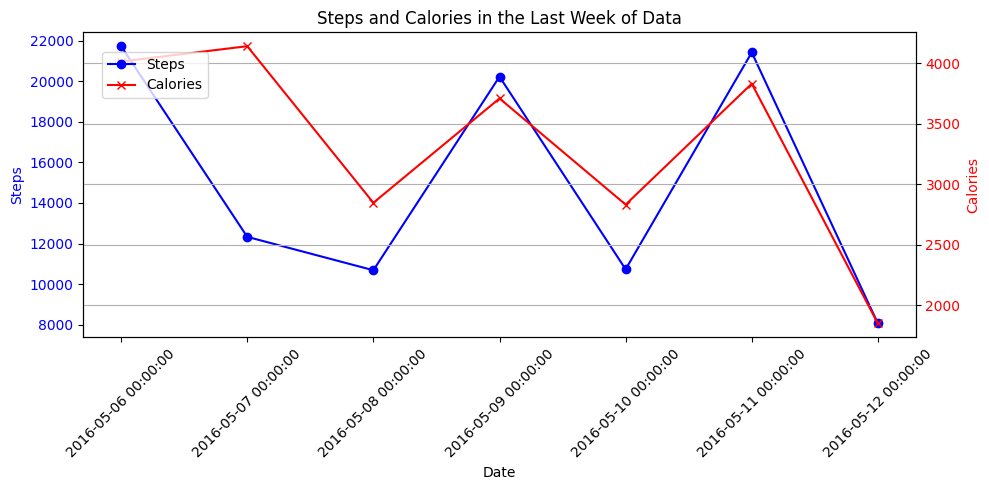

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import torch

# データの読み込み
data = pd.read_csv('/content/dailyActivity_merged.csv')

# 必要な列の抽出
data = data[['ActivityDate', 'Calories', 'TotalSteps']]

# 日付データの変換
data['ActivityDate'] = pd.to_datetime(data['ActivityDate'])

print("Test Data:")
print(data)
print("Dataset Information:")
print(data.describe())


# データ内の1週間の歩数のグラフを表示
import matplotlib.pyplot as plt

# データ内の1週間の歩数と消費カロリーのグラフを表示
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(data['ActivityDate'][-7:], data['TotalSteps'][-7:], marker='o', color='b', label='Steps')
ax1.set_xlabel('Date')
ax1.set_ylabel('Steps', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticklabels(data['ActivityDate'][-7:], rotation=45)
ax2 = ax1.twinx()
ax2.plot(data['ActivityDate'][-7:], data['Calories'][-7:], marker='x', color='r', label='Calories')
ax2.set_ylabel('Calories', color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.grid(True)
plt.title('Steps and Calories in the Last Week of Data')
fig.tight_layout()
fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))

plt.show()

# データの標準化
scaler = StandardScaler()
data[['Calories', 'TotalSteps']] = scaler.fit_transform(data[['Calories', 'TotalSteps']])

# 訓練データとテストデータに分割
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

# 特徴量とターゲットの設定
X_train = train_data[['Calories']].values
y_train = train_data['TotalSteps'].values
X_test = test_data[['Calories']].values
y_test = test_data['TotalSteps'].values

# PyTorch用にデータをテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)


### Linear Regression Model


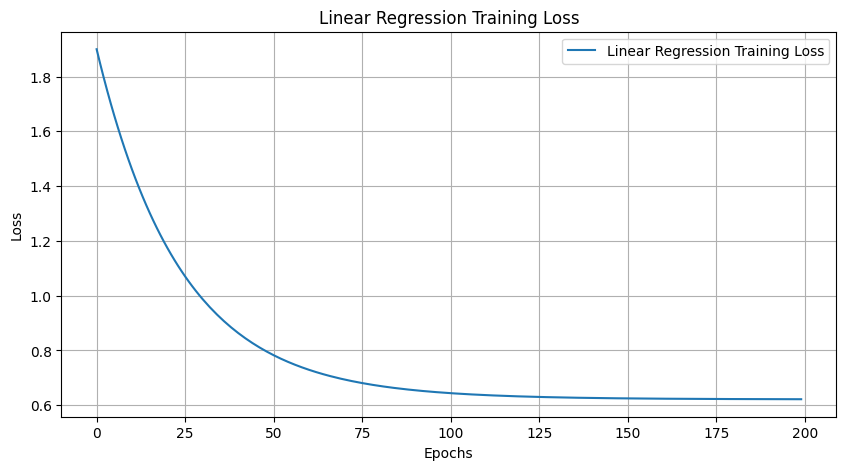

Linear Regression MAE: 1.080173705325764


In [ ]:
import torch.nn as nn
import torch.optim as optim

# 線形回帰モデルの定義
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)

# モデルの初期化
lr_model = LinearRegressionModel()
criterion = nn.MSELoss()
optimizer = optim.SGD(lr_model.parameters(), lr=0.01)

# モデルの訓練
epochs = 200
losses = []
for epoch in range(epochs):
    lr_model.train()
    optimizer.zero_grad()
    outputs = lr_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

# 学習過程の表示
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), losses, label='Linear Regression Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Linear Regression Training Loss')
plt.legend()
plt.grid(True)
plt.show()

# 予測と評価
lr_model.eval()
y_pred_lr = lr_model(X_test_tensor).detach().numpy()
mae_lr = np.mean(np.abs(y_test - y_pred_lr))
print(f'Linear Regression MAE: {mae_lr}')

### ARIMA Model

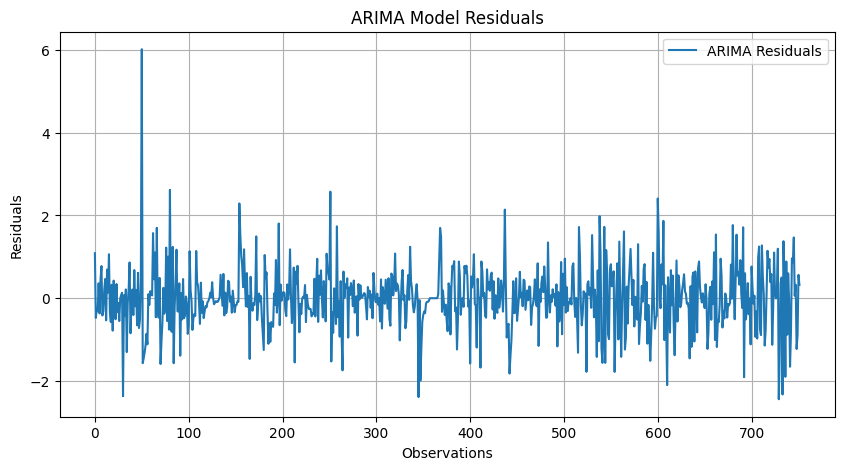

ARIMA MAE: 1.021898636579699


In [ ]:
import statsmodels.api as sm

# ARIMAモデルの定義とフィッティング
arima_model = sm.tsa.ARIMA(y_train, order=(5, 1, 0))
arima_model_fit = arima_model.fit()

# 学習過程の表示
plt.figure(figsize=(10, 5))
plt.plot(arima_model_fit.resid, label='ARIMA Residuals')
plt.xlabel('Observations')
plt.ylabel('Residuals')
plt.title('ARIMA Model Residuals')
plt.legend()
plt.grid(True)
plt.show()

# 予測と評価
y_pred_arima = arima_model_fit.forecast(steps=len(y_test))
mae_arima = mean_absolute_error(y_test, y_pred_arima)
print(f'ARIMA MAE: {mae_arima}')


### XGBoost Model

[0]	validation_0-mae:0.95042
[1]	validation_0-mae:0.89021
[2]	validation_0-mae:0.85285
[3]	validation_0-mae:0.83017
[4]	validation_0-mae:0.81716
[5]	validation_0-mae:0.81083
[6]	validation_0-mae:0.80906
[7]	validation_0-mae:0.80438
[8]	validation_0-mae:0.80315
[9]	validation_0-mae:0.80332
[10]	validation_0-mae:0.80621
[11]	validation_0-mae:0.80705
[12]	validation_0-mae:0.80826
[13]	validation_0-mae:0.81020
[14]	validation_0-mae:0.81170
[15]	validation_0-mae:0.81134
[16]	validation_0-mae:0.81179
[17]	validation_0-mae:0.81215
[18]	validation_0-mae:0.81371
[19]	validation_0-mae:0.81445
[20]	validation_0-mae:0.81801
[21]	validation_0-mae:0.81737
[22]	validation_0-mae:0.81755
[23]	validation_0-mae:0.81894
[24]	validation_0-mae:0.81647
[25]	validation_0-mae:0.81685
[26]	validation_0-mae:0.81816
[27]	validation_0-mae:0.81795
[28]	validation_0-mae:0.81825
[29]	validation_0-mae:0.81856
[30]	validation_0-mae:0.81759
[31]	validation_0-mae:0.81795
[32]	validation_0-mae:0.81861
[33]	validation_0-ma

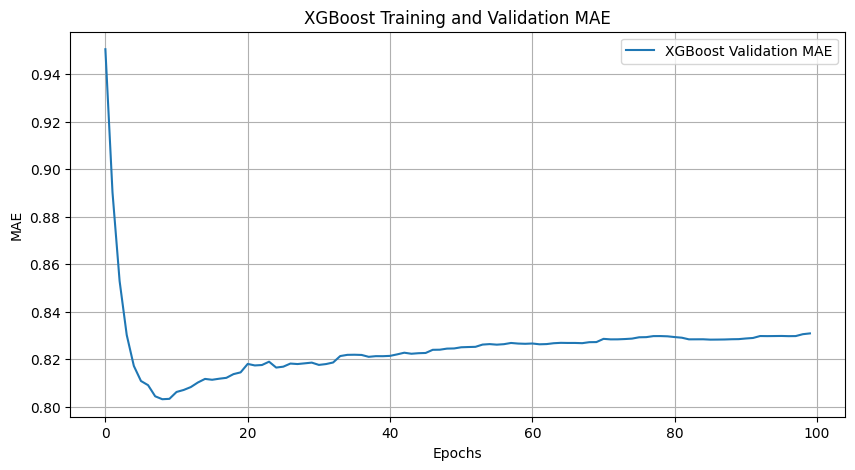

XGBoost MAE: 0.8308484201638685


In [ ]:
import xgboost as xgb

# データの再構成
X_train_xgb = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
X_test_xgb = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))

# モデルの訓練
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae')
xgb_model.fit(X_train_xgb, y_train, eval_set=[(X_test_xgb, y_test)], verbose=True)

# 学習過程の表示
results = xgb_model.evals_result()
epochs = len(results['validation_0']['mae'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 5))
plt.plot(x_axis, results['validation_0']['mae'], label='XGBoost Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('XGBoost Training and Validation MAE')
plt.legend()
plt.grid(True)
plt.show()

# 予測と評価
y_pred_xgb = xgb_model.predict(X_test_xgb)
mae_xgb = np.mean(np.abs(y_test - y_pred_xgb))
print(f'XGBoost MAE: {mae_xgb}')


### RNN + LSTM Model

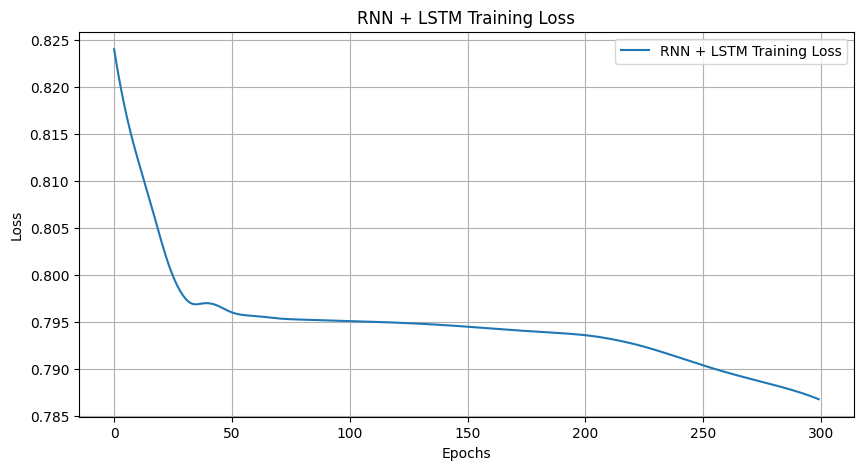

RNN + LSTM MAE: 0.9431742887185397


In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch

# RNN + LSTMモデルの定義
class RNNLSTMModel(nn.Module):
    def __init__(self, input_dim, rnn_hidden_dim, lstm_hidden_dim, output_dim, num_layers):
        super(RNNLSTMModel, self).__init__()
        self.rnn_hidden_dim = rnn_hidden_dim
        self.lstm_hidden_dim = lstm_hidden_dim
        self.num_layers = num_layers

        self.rnn = nn.RNN(input_dim, rnn_hidden_dim, num_layers, batch_first=True)
        self.lstm = nn.LSTM(rnn_hidden_dim, lstm_hidden_dim, num_layers, batch_first=True)

        self.fc = nn.Linear(lstm_hidden_dim, output_dim)

    def forward(self, x):
        h0_rnn = torch.zeros(self.num_layers, x.size(0), self.rnn_hidden_dim).to(x.device)
        rnn_out, _ = self.rnn(x, h0_rnn)

        # LSTMの初期隠れ状態とセル状態
        h0_lstm = torch.zeros(self.num_layers, x.size(0), self.lstm_hidden_dim).to(x.device)
        c0_lstm = torch.zeros(self.num_layers, x.size(0), self.lstm_hidden_dim).to(x.device)

        # LSTM層を通過
        lstm_out, _ = self.lstm(rnn_out, (h0_lstm, c0_lstm))

        out = self.fc(lstm_out[:, -1, :])
        return out

# モデルの初期化
rnn_model = RNNLSTMModel(input_dim=1, rnn_hidden_dim=50, lstm_hidden_dim=50, output_dim=1, num_layers=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

# データの再構成
def create_rnn_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 1
X_train_rnn, y_train_rnn = create_rnn_dataset(X_train, y_train, time_steps)
X_test_rnn, y_test_rnn = create_rnn_dataset(X_test, y_test, time_steps)

X_train_rnn_tensor = torch.tensor(X_train_rnn, dtype=torch.float32)
y_train_rnn_tensor = torch.tensor(y_train_rnn, dtype=torch.float32).unsqueeze(1)
X_test_rnn_tensor = torch.tensor(X_test_rnn, dtype=torch.float32)
y_test_rnn_tensor = torch.tensor(y_test_rnn, dtype=torch.float32).unsqueeze(1)

epochs = 300
losses = []
for epoch in range(epochs):
    rnn_model.train()
    optimizer.zero_grad()
    outputs = rnn_model(X_train_rnn_tensor)
    loss = criterion(outputs, y_train_rnn_tensor)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

# 学習過程の表示
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), losses, label='RNN + LSTM Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('RNN + LSTM Training Loss')
plt.legend()
plt.grid(True)
plt.show()

# 予測と評価
rnn_model.eval()
y_pred_rnn = rnn_model(X_test_rnn_tensor).detach().numpy()
mae_rnn = mean_absolute_error(y_test_rnn, y_pred_rnn)
print(f'RNN + LSTM MAE: {mae_rnn}')

## Experiments & Results
The results of the predictions differed significantly in each model.
This may be due to the different characteristics captured in each model.
The results were relatively stable when using ensemble learning. We can now check the difference between the actual number of steps taken and the number of steps taken by a healthy person who exercises. This result shows that this kind of indicator can be used.


In [ ]:
# 新しいデータセットの定義
new_data = pd.DataFrame({
    'Date': ['2024-07-21', '2024-07-22', '2024-07-23', '2024-07-24', '2024-07-25', '2024-07-26', '2024-07-27'],
    'TotalSteps': [1346, 1740, 944, 7275, 1945, 2373, 5060],
    'Calories': [73, 227, 321, 448, 254, 250, 833]
})

# 日付データの変換
new_data['Date'] = pd.to_datetime(new_data['Date'])

# データの標準化（Fitbitデータセットのスケーラーを使用）
new_data[['Calories', 'TotalSteps']] = scaler.transform(new_data[['Calories', 'TotalSteps']])

# 新しいデータセットの特徴量を取得
X_new = new_data[['Calories']].values
X_new_tensor = torch.tensor(X_new, dtype=torch.float32)

# 線形回帰モデルの予測
lr_model.eval()
y_pred_new_lr = lr_model(X_new_tensor).detach().numpy()

# RNN + LSTMモデルの予測
X_new_rnn, _ = create_rnn_dataset(X_new, new_data['TotalSteps'].values, time_steps)
X_new_rnn_tensor = torch.tensor(X_new_rnn, dtype=torch.float32)
rnn_model.eval()
y_pred_new_rnn = rnn_model(X_new_rnn_tensor).detach().numpy().flatten()

# ARIMAモデルの予測
y_pred_new_arima = arima_model_fit.forecast(steps=len(X_new))

# XGBoostモデルの予測
y_pred_new_xgb = xgb_model.predict(X_new)

# 標準化を元に戻す
new_data[['Calories', 'TotalSteps']] = scaler.inverse_transform(new_data[['Calories', 'TotalSteps']])

# RNNの予測結果を7日分に拡張
y_pred_new_rnn_full = np.concatenate((np.zeros(time_steps), y_pred_new_rnn))

# 結果の表示（標準化を元に戻す）
new_data['PredictedSteps_LR'] = y_pred_new_lr * scaler.scale_[1] + scaler.mean_[1]
new_data['PredictedSteps_RNN'] = y_pred_new_rnn_full * scaler.scale_[1] + scaler.mean_[1]
new_data['PredictedSteps_ARIMA'] = y_pred_new_arima * scaler.scale_[1] + scaler.mean_[1]
new_data['PredictedSteps_XGBoost'] = y_pred_new_xgb * scaler.scale_[1] + scaler.mean_[1]

print(new_data)

        Date  TotalSteps  Calories  PredictedSteps_LR  PredictedSteps_RNN  \
0 2024-07-21      1346.0      73.0         117.386719         7637.910638   
1 2024-07-22      1740.0     227.0         630.453613         5928.177481   
2 2024-07-23       944.0     321.0         943.624023         5877.058519   
3 2024-07-24      7275.0     448.0        1366.738281         5852.990380   
4 2024-07-25      1945.0     254.0         720.406738         5831.854614   
5 2024-07-26      2373.0     250.0         707.080078         5869.510898   
6 2024-07-27      5060.0     833.0        2649.404785         5870.598567   

   PredictedSteps_ARIMA  PredictedSteps_XGBoost  
0           7945.483303              209.180664  
1           7834.482302              209.180664  
2           7485.231988               92.044434  
3           7583.456585               92.044434  
4           8263.738543              209.180664  
5           8312.604381              209.180664  
6           7975.822141          

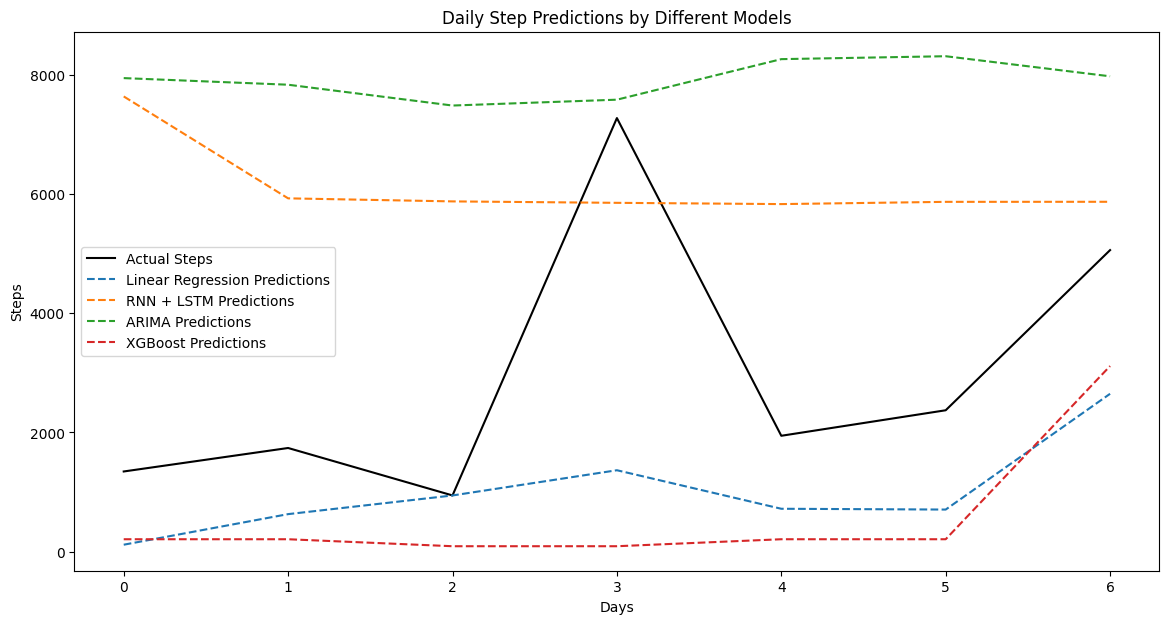

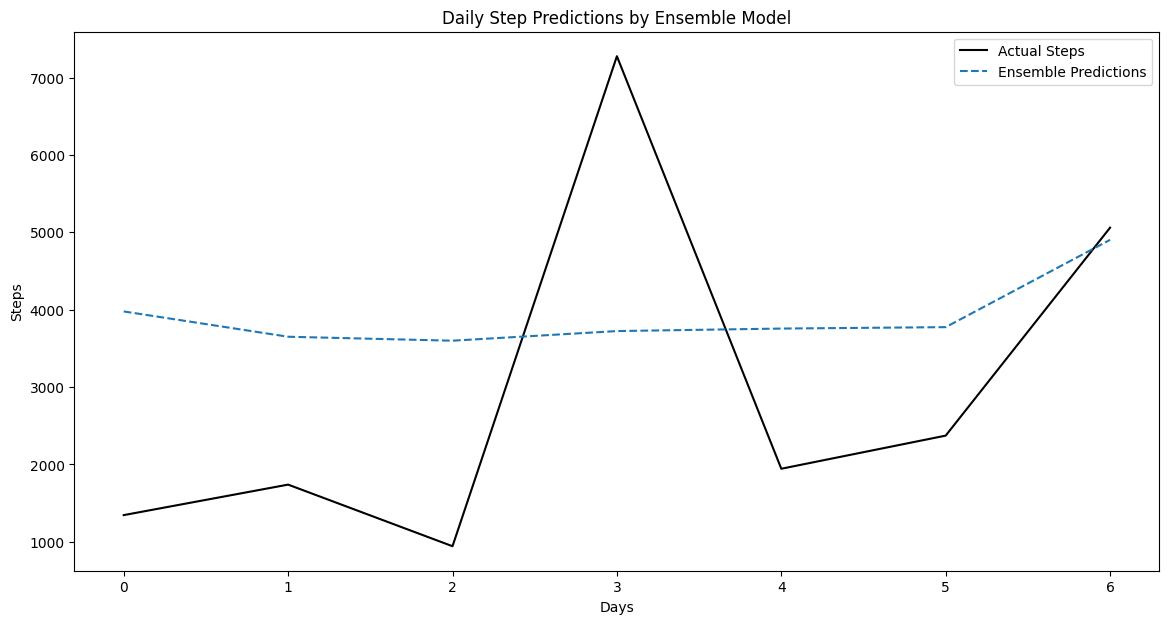

In [ ]:

# 実際の歩数データ
actual_steps = new_data['TotalSteps'].values

# 各モデルの予測結果
predicted_steps_lr = new_data['PredictedSteps_LR'].values
predicted_steps_rnn = new_data['PredictedSteps_RNN'].values
predicted_steps_arima = new_data['PredictedSteps_ARIMA'].values
predicted_steps_xgb = new_data['PredictedSteps_XGBoost'].values

# 各モデルの予測結果をプロット
plt.figure(figsize=(14, 7))
plt.plot(actual_steps, label='Actual Steps', color='black')
plt.plot(predicted_steps_lr, label='Linear Regression Predictions', linestyle='--')
plt.plot(predicted_steps_rnn, label='RNN + LSTM Predictions', linestyle='--')
plt.plot(predicted_steps_arima, label='ARIMA Predictions', linestyle='--')
plt.plot(predicted_steps_xgb, label='XGBoost Predictions', linestyle='--')

plt.xlabel('Days')
plt.ylabel('Steps')
plt.title('Daily Step Predictions by Different Models')
plt.legend()
plt.show()

# アンサンブル予測結果を取得
ensemble_predictions = np.mean(np.array([predicted_steps_lr, predicted_steps_rnn, predicted_steps_arima, predicted_steps_xgb]), axis=0)

# アンサンブル予測結果をプロット
plt.figure(figsize=(14, 7))
plt.plot(actual_steps, label='Actual Steps', color='black')
plt.plot(ensemble_predictions, label='Ensemble Predictions', linestyle='--')

plt.xlabel('Days')
plt.ylabel('Steps')
plt.title('Daily Step Predictions by Ensemble Model')
plt.legend()
plt.show()
